## E-Commerce User Behavior Analysis and Recommendation System

This project focuses on analyzing real-world e-commerce interaction data to improve recommendation systems and detect abnormal browsing behavior.  
We will follow the **CRISP-DM** framework to ensure a structured approach.

**Objectives:**
1. **Predict item properties** (such as price range, vendor, and product type) for products added to cart, using patterns from the same user's prior view events.
2. **Detect abnormal users** whose browsing patterns significantly deviate from normal behavior, in order to:
   - Reduce noise and bias in the recommendation system.
   - Improve the accuracy of split testing and overall analytics.

The workflow includes:
- Business understanding and formulation of analytical questions.
- Extensive data exploration and preprocessing.
- Visualization of behavioral trends.
- Machine learning modeling for both property prediction and anomaly detection.
- Actionable recommendations for business decision-making.


In [2]:
!pip install implicit==0.7.2 --no-cache-dir --prefer-binary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 13.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for implicit: filename=implicit-0.7.2-cp312-cp312-linux_x86_64.whl size=10854003 sha256=4b348de3b39e7ec854c9441ae5e78c0057fa3a8b7627c6755088cb5688ac6959
  Stored in directory: /tmp/pip-ephem-wheel-cache-sgumdmtq/wheels/b2/00/4f/9ff8af07a0a53ac6007ea5d739da19cfe147a2df542b6899f8
Successfully built implicit


In [9]:
import numpy as np
import pandas as pd
import math
import os
import duckdb
import scipy.sparse as sp
import seaborn as sns
import matplotlib.pyplot as plt
import psutil, os
import random
import implicit



from tqdm import tqdm
from time import time
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier,IsolationForest
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold,cross_val_score,StratifiedKFold
from sklearn.model_selection import validation_curve
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,ndcg_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import classification_report,roc_auc_score,f1_score,accuracy_score,roc_curve
from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance
from scipy import sparse
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from scipy.sparse import csr_matrix
from sklearn.model_selection import TimeSeriesSplit
from sklearn.decomposition import PCA
from collections import defaultdict
from imblearn.over_sampling import SMOTE



from warnings import simplefilter
simplefilter("ignore")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# List the contents of the specified Google Drive folder
!ls "/content/drive/My Drive/Colab Data/TMP"

'About Recommendation System Dataset.pdf'    item_properties_filter.csv
 category_tree.csv			     item_properties_part1.1.csv
'Copy Property_Recommendation-Copy1.ipynb'   item_properties_part2.csv
 events.csv				     merged_properties_events.csv
 item_properties.csv			     Property_Recommendation.ipynb


In [5]:
os.chdir('/content/drive/My Drive/Colab Data/TMP')

!pwd

/content/drive/My Drive/Colab Data/TMP


### Exploratory Data Analysis (EDA)
Understanding Data Structure

In [ ]:
events = pd.read_csv("events.csv")
item_prop01 = pd.read_csv("item_properties_part1.1.csv")
item_prop02 = pd.read_csv("item_properties_part2.csv")
category_tree = pd.read_csv("category_tree.csv")

print("EVENTS TABLE:")
display(events.head())
print("\nITEM PROPERTIES 1 TABLE:")
display(item_prop01.head())
print("\nITEM PROPERTIES 2 TABLE:")
display(item_prop02.head())
print("\nCATEGORY TREE TABLE:")
display(category_tree.head())

EVENTS TABLE:


,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN



ITEM PROPERTIES 1 TABLE:


,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513



ITEM PROPERTIES 2 TABLE:


,timestamp,itemid,property,value
0,1433041200000,183478,561,769062
1,1439694000000,132256,976,n26.400 1135780
2,1435460400000,420307,921,1149317 1257525
3,1431831600000,403324,917,1204143
4,1435460400000,230701,521,769062



CATEGORY TREE TABLE:


,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [ ]:
print("Events shape:", events.shape)
print("Item Props 1 shape:", item_prop01.shape)
print("Item Props 2 shape:", item_prop02.shape)
print("Category Tree shape:", category_tree.shape)

Events shape: (2756101, 5)
Item Props 1 shape: (10999999, 4)
Item Props 2 shape: (9275903, 4)
Category Tree shape: (1669, 2)


In [ ]:
# Concatenate item_prop1 and item_prop2
item_prop = pd.concat([item_prop01, item_prop02], axis=0, ignore_index=True)

# Preview result
print("Shape of concatenated dataframe:", item_prop.shape)
print(item_prop.head())


Shape of concatenated dataframe: (20275902, 4)
       timestamp  itemid    property                            value
0  1435460400000  460429  categoryid                             1338
1  1441508400000  206783         888          1116713 960601 n277.200
2  1439089200000  395014         400  n552.000 639502 n720.000 424566
3  1431226800000   59481         790                       n15360.000
4  1431831600000  156781         917                           828513


In [ ]:
# Save merged file
item_prop.to_csv("/content/drive/My Drive/Colab Data/TMP/item_properties.csv", index=False)

In [ ]:
# Filter out rows where property is 'categoryid' or 'available'
item_prop1 = item_prop[
    item_prop['property'].isin(['categoryid', 'available'])
]

# Save to CSV
item_prop1.to_csv("/content/drive/My Drive/Colab Data/TMP/item_properties_filter.csv", index=False)


In [ ]:
item_prop1.head(20)

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
5,1436065200000,285026,available,0
15,1437274800000,186518,available,0
79,1433646000000,423682,available,0
82,1434250800000,316253,available,1
96,1437274800000,430459,available,0
101,1433041200000,411262,available,0
116,1441508400000,50372,available,0
119,1441508400000,289043,available,0
133,1435460400000,365407,available,0


In [ ]:
item_prop1.shape

(2291853, 4)

### Preprocessing & Cleaning

In [ ]:
# Convert timestamps to human-readable dates
events['datetime'] = pd.to_datetime(events['timestamp'], unit='ms')
print(events['event'].value_counts())

# Transaction ID only for purchases
print(events[events['event'] == 'transaction']['transactionid'].notna().mean())

# Summary statistics for events
events_summary = events.groupby('event')['itemid'].count().reset_index()
events_summary.columns = ['event', 'count']

print(events_summary)


event
view           2664312
addtocart        69332
transaction      22457
Name: count, dtype: int64
1.0
         event    count
0    addtocart    69332
1  transaction    22457
2         view  2664312


In [ ]:
# Convert timestamp column from milliseconds to datetime
item_prop1['date'] = pd.to_datetime(item_prop1['timestamp'], unit='ms')


In [ ]:
print(events.isna().sum())

timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733644
datetime               0
dtype: int64


In [ ]:
events[['timestamp', 'datetime']].head(10)

,timestamp,datetime
0,1433221332117,2015-06-02 05:02:12.117
1,1433224214164,2015-06-02 05:50:14.164
2,1433221999827,2015-06-02 05:13:19.827
3,1433221955914,2015-06-02 05:12:35.914
4,1433221337106,2015-06-02 05:02:17.106
5,1433224086234,2015-06-02 05:48:06.234
6,1433221923240,2015-06-02 05:12:03.240
7,1433223291897,2015-06-02 05:34:51.897
8,1433220899221,2015-06-02 04:54:59.221
9,1433221204592,2015-06-02 05:00:04.592


In [ ]:
# Convert timestamp
item_prop1['datetime'] = pd.to_datetime(item_prop1['timestamp'], unit='ms')

# Check property types
print(item_prop1['property'].value_counts().head(20))

property
available     1503639
categoryid     788214
Name: count, dtype: int64


In [ ]:
# Check missing values
print(item_prop1.isna().sum())

timestamp    0
itemid       0
property     0
value        0
date         0
datetime     0
dtype: int64


In [ ]:
# Check how many rows in 'value' start with 'n'
n_count = item_prop1['value'].astype(str).str.startswith('n').sum()

# Total rows in the dataframe
total_count = len(item_prop1)

# Percentage
percentage = (n_count / total_count) * 100

print(f"Total rows: {total_count}")
print(f"Rows starting with 'n': {n_count}")
print(f"Percentage: {percentage:.2f}%")


Total rows: 2291853
Rows starting with 'n': 0
Percentage: 0.00%


In [ ]:
# Start from events
events_merged = events.copy()

#  Bring categoryid from item_properties
category_info = item_prop1[item_prop1['property'] == 'categoryid'][['itemid', 'value']]
category_info = category_info.rename(columns={'value': 'categoryid'})

# Merge events with categoryid
events_merged = events_merged.merge(category_info, on='itemid', how='left')

# Ensure both categoryid columns are the same type
events_merged['categoryid'] = events_merged['categoryid'].astype(str)
category_tree['categoryid'] = category_tree['categoryid'].astype(str)

# Merge with category_tree to add category names/hierarchy
events_merged = events_merged.merge(category_tree, on='categoryid', how='left')

# Preview
print(events_merged.head())


       timestamp  visitorid event  itemid  transactionid  \
0  1433221332117     257597  view  355908            NaN   
1  1433224214164     992329  view  248676            NaN   
2  1433221999827     111016  view  318965            NaN   
3  1433221955914     483717  view  253185            NaN   
4  1433221337106     951259  view  367447            NaN   

                 datetime categoryid  parentid  
0 2015-06-02 05:02:12.117       1173     805.0  
1 2015-06-02 05:50:14.164       1231     901.0  
2 2015-06-02 05:13:19.827        nan       NaN  
3 2015-06-02 05:12:35.914        914     226.0  
4 2015-06-02 05:02:17.106       1613     250.0  


In [ ]:
# Number of unique items
print("Unique items:", item_prop1['itemid'].nunique())

Unique items: 417053


In [ ]:
# Example: availability over time
availability = item_prop1[item_prop1['property'] == 'available']
availability['datetime'] = pd.to_datetime(availability['timestamp'], unit='ms')
availability['value'] = availability['value'].astype(int)
print(availability['value'].value_counts())

# Price-related properties (look for 'n' prefix)
price_data = item_prop1[item_prop1['value'].astype(str).str.startswith('n')]
print(price_data.head())

value
0    863086
1    640553
Name: count, dtype: int64
Empty DataFrame
Columns: [timestamp, itemid, property, value, date, datetime]
Index: []


In [ ]:
# Check if category hierarchy is valid
print(category_tree.isna().sum())

categoryid     0
parentid      25
dtype: int64


In [ ]:
print("Unique categories:", category_tree['categoryid'].nunique())

Unique categories: 1669


### Data Analysis & Bussiness Questions
1. Event distribution →
"What proportion of customer interactions are views, additions to cart, or purchases?"

2. Events over time →
"Do customer interactions show seasonal trends, weekly patterns, or sudden spikes that could indicate campaigns or issues?"

3. Top viewed items →
"Which products generate the most interest from customers?"

4. Availability trend →
"Has product availability improved or worsened over time, and could this be impacting sales?"

5. Category popularity →
"Which product categories attract the most attention from customers?"

6. Conversion funnel performance →
"What percentage of views convert into purchases, and which events lose the most customers?"

8. Predictive Recommendation System →
"Using customer behaviour and interaction pattern , how can we recommend interest based properties and detect anamolies ?"

#### 1. Events Distribution

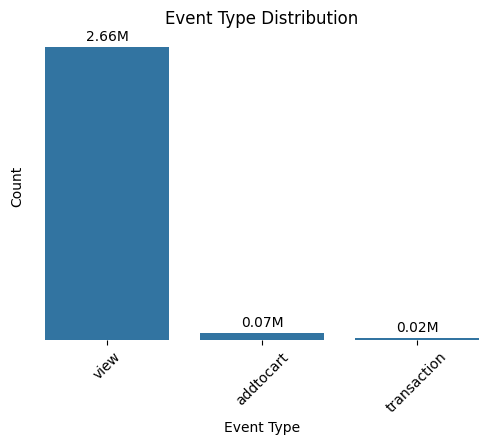

In [ ]:
plt.figure(figsize=(6,4))
ax = sns.countplot(data=events, x='event', order=events['event'].value_counts().index)
plt.title("Event Type Distribution")
plt.xlabel("Event Type")
plt.ylabel("Count")

# Add labels with billions format (adjust as needed)
for container in ax.containers:
    ax.bar_label(
        container,
        labels=[f'{v.get_height()/1e6:.2f}M' for v in container],  # comma-separated integers
        label_type='edge',
        padding=2
    )

plt.xticks(rotation=45)
plt.yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)
plt.show()


#### Event over time

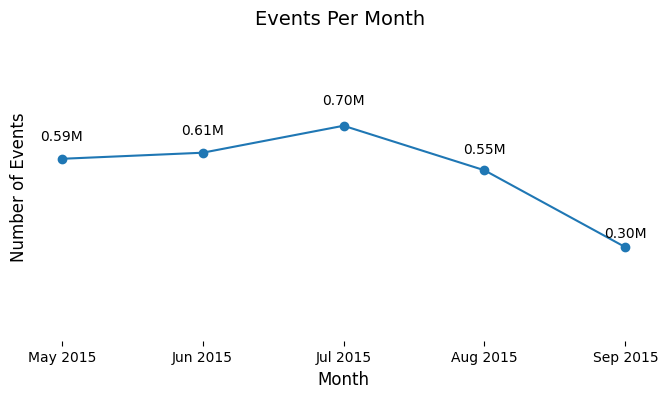

In [ ]:
# Group by month
events_monthly = events.groupby(events['datetime'].dt.to_period('M')).size()

# Convert index to string labels (e.g., "2015-06")
months = events_monthly.index.strftime('%b %Y')

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(months, events_monthly.values, marker='o', linestyle='-')

# Labels & title
ax.set_title("Events Per Month ", fontsize=14)
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Number of Events", fontsize=12)

# Add labels with offset
offset = 0.10
for i, val in enumerate(events_monthly.values):
    ax.text(i, val + offset * val, f"{val/1e6:.2f}M", ha='center', fontsize=10)

# Remove surrounding border (spines)
for spine in ax.spines.values():
    spine.set_visible(False)

# Remove grid
ax.grid(False)
ax.set_ylim(0,1e6)
ax.yaxis.set_ticks([])
ax.yaxis.set_ticklabels([])
plt.show()


#### Top 10 Most Viewed Items

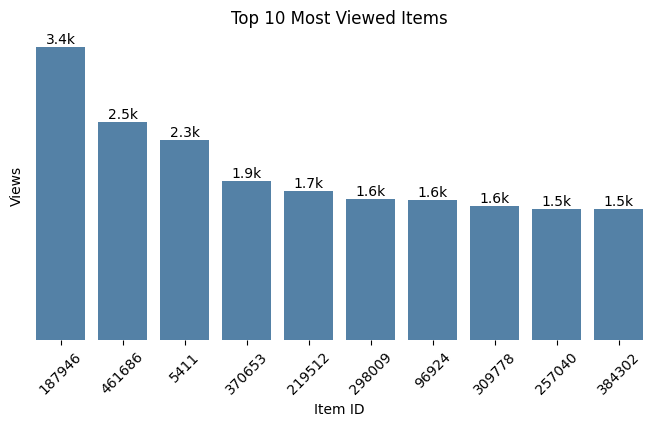

In [ ]:
def add_bar_labels(ax):
    for p in ax.patches:
        value = p.get_height()
        label = f'{value/1000:.1f}k'  # ✅ rounded to 1 decimal in thousands
        ax.annotate(label,
                    (p.get_x() + p.get_width()/2, value),
                    ha='center', va='bottom')

# Plot
top_viewed_items = events[events['event'] == 'view']['itemid'].value_counts().head(10)

plt.figure(figsize=(8,4))
ax = sns.barplot(x=top_viewed_items.index.astype(str),
                 y=top_viewed_items.values,
                 color="steelblue")

plt.title("Top 10 Most Viewed Items")
plt.xlabel("Item ID")
plt.ylabel("Views")

add_bar_labels(ax)  #  labels like "12.3k"

plt.xticks(rotation=45)
plt.yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)
plt.show()


#### Category Distribution

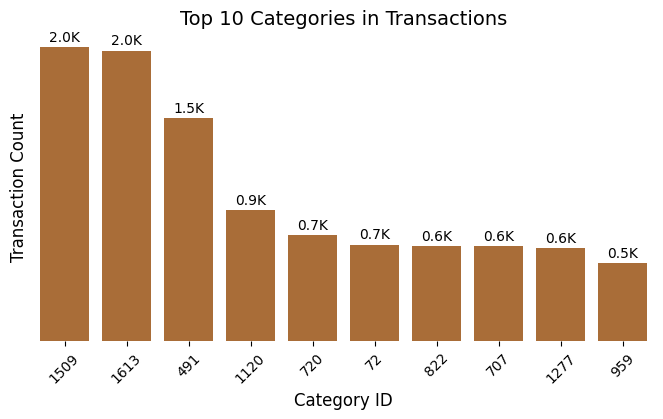

In [ ]:
# Merge events with categoryid first
category_info = item_prop1[item_prop1['property'] == 'categoryid'][['itemid', 'value']]
category_info = category_info.rename(columns={'value': 'categoryid'})

# Ensure both categoryid columns are the same type before merging
events['itemid'] = events['itemid'].astype(str)
category_info['itemid'] = category_info['itemid'].astype(str)
category_info['categoryid'] = category_info['categoryid'].astype(str)


events_merged = events.merge(category_info, on='itemid', how='left')

# Now filter for transactions from the merged data
transactions = events_merged[events_merged["event"] == "transaction"].copy()

# --- 2. Get price info from item properties
prices = item_prop1[item_prop1["property"] == "price"].copy()
prices["value"] = pd.to_numeric(prices["value"], errors="coerce")

# Ensure itemid is string for merging with prices
prices['itemid'] = prices['itemid'].astype(str)

# --- 3. Merge transactions with price
tx_price = transactions.merge(prices[["itemid", "value"]],
                              on="itemid", how="left")
tx_price.rename(columns={"value": "price"}, inplace=True)

# --- 4. Compute revenue by product
product_revenue = tx_price.groupby("itemid")["price"].sum().reset_index()

# --- 5. Get category mapping (already done in the first merge, but keeping this for potential future use or clarity)
categories = item_prop1[item_prop1["property"] == "categoryid"][["itemid", "value"]]
categories.rename(columns={"value": "categoryid"}, inplace=True)

# Ensure itemid is string for merging
categories['itemid'] = categories['itemid'].astype(str)

# Merge category information into product_revenue
product_revenue = product_revenue.merge(categories, on="itemid", how="left") # This merge is now redundant for categoryid

# Ensure categoryid is string and handle potential NaNs before grouping
product_revenue['categoryid'] = product_revenue['categoryid'].astype(str).fillna('Unknown')


# --- 6. Aggregate by category
category_revenue = product_revenue.groupby("categoryid")["price"].sum().reset_index()
category_revenue = category_revenue.sort_values("price", ascending=False)

# Count top 10
category_counts_tx = transactions['categoryid'].value_counts().head(10)

# Convert to DataFrame for plotting
category_counts_tx = category_counts_tx.reset_index()
category_counts_tx.columns = ['categoryid', 'count']

# Plot in descending order
plt.figure(figsize=(8,4))
ax = sns.barplot(
    x='categoryid',
    y='count',
    data=category_counts_tx,
    order=category_counts_tx.sort_values('count', ascending=False)['categoryid'],  # ✅ ensures descending order
    color='#BC6C25'
)

plt.title("Top 10 Categories in Transactions", fontsize=14)
plt.xlabel("Category ID", fontsize=12)
plt.ylabel("Transaction Count", fontsize=12)

# Add labels in thousands
for container in ax.containers:
    ax.bar_label(
        container,
        labels=[f'{v.get_height()/1e3:.1f}K' for v in container],
        label_type='edge',
        padding=2
    )

plt.xticks(rotation=45)
plt.yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)

plt.show()

### Average Availability Trend

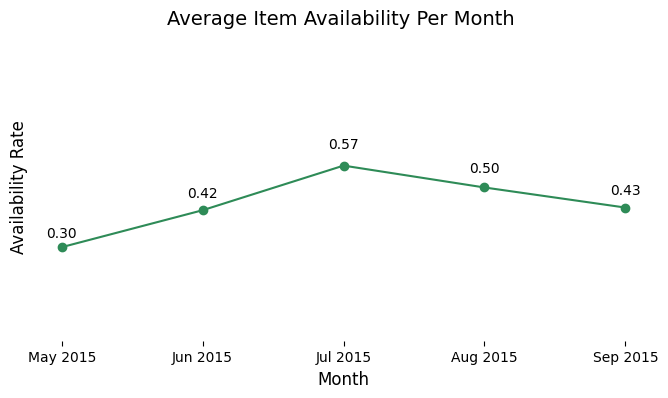

In [ ]:
# Group by month
availability['datetime'] = pd.to_datetime(availability['timestamp'], unit='ms')

availability_monthly = availability.groupby(availability['datetime'].dt.to_period('M'))['value'].mean()

# Convert index to string labels (e.g., "2015-06")
months = availability_monthly.index.strftime('%b %Y')

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(months, availability_monthly.values, marker='o', linestyle='-', color='seagreen')

# Labels & title
ax.set_title("Average Item Availability Per Month ", fontsize=14)
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Availability Rate", fontsize=12)

# Add labels with offset
offset = 0.10
for i, val in enumerate(availability_monthly.values):
    ax.text(i, val + offset * val,f"{val:.2f}", ha='center', fontsize=10)
# Remove surrounding border (spines)
for spine in ax.spines.values():
    spine.set_visible(False)

# Remove grid
ax.grid(False)
ax.set_ylim(0,1)
ax.yaxis.set_ticks([])
ax.yaxis.set_ticklabels([])
plt.show()


#### Conversion funnel performance

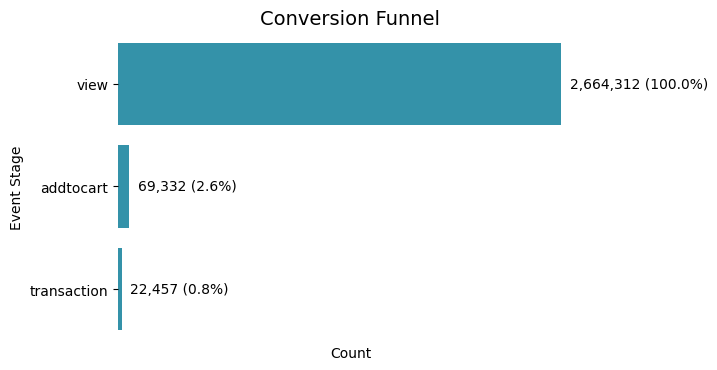

In [ ]:
funnel_counts = events['event'].value_counts()
funnel_order = ['view', 'addtocart', 'transaction']

# Keep only the funnel events in the correct order
funnel_counts = funnel_counts.reindex(funnel_order)

# Step 2: Calculate percentages
funnel_percentages = (funnel_counts / funnel_counts.iloc[0]) * 100

# Step 3: Plot horizontal funnel
plt.figure(figsize=(6,4))
ax = sns.barplot(
    y=funnel_counts.index,
    x=funnel_counts.values,
    order=funnel_order,
    color='#219ebc'
)

# Titles and labels
plt.title("Conversion Funnel", fontsize=14)
plt.xlabel("Count")
plt.ylabel("Event Stage")

# Add data labels (count + %)
for i, v in enumerate(funnel_counts.values):
    ax.text(
        v + (0.02 * funnel_counts.max()),  # small horizontal offset
        i,
        f"{v:,} ({funnel_percentages.iloc[i]:.1f}%)",
        va='center',
        fontsize=10
    )

# Remove x-axis ticks & borders
plt.xticks([])
for spine in ax.spines.values():
    spine.set_visible(False)

plt.show()


#### Predictive Recommendation System

##### Data Merging and Pivot Table

In [ ]:
events['itemid'] = pd.to_numeric(events['itemid'], errors='coerce')
item_prop1['itemid'] = pd.to_numeric(item_prop1['itemid'], errors='coerce')

In [ ]:
# Register in DuckDB
duckdb.register('events', events)
duckdb.register('item_prop1', item_prop1)

# Merge & pivot categoryid and available
full_merged = duckdb.query("""
WITH props AS (
    SELECT
        itemid,
        timestamp,
        MAX(CASE WHEN property = 'categoryid' THEN value END) AS categoryid,
        MAX(CASE WHEN property = 'available' THEN value END) AS available
    FROM item_prop1
    GROUP BY itemid, timestamp
),
latest_props AS (
    SELECT *
    FROM (
        SELECT
            e.*,
            p.categoryid,
            p.available,
            ROW_NUMBER() OVER (
                PARTITION BY e.itemid, e.timestamp
                ORDER BY p.timestamp DESC
            ) AS rn
        FROM events e
        LEFT JOIN props p
        ON e.itemid = p.itemid
        AND p.timestamp <= e.timestamp
    )
    WHERE rn = 1
)
SELECT * EXCLUDE (rn)
FROM latest_props
""").to_df()

# Save merged file
full_merged.to_csv("/content/drive/My Drive/Colab Data/TMP/merged_properties_events.csv", index=False)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [6]:
full_merged = pd.read_csv("/content/drive/My Drive/Colab Data/TMP/merged_properties_events.csv")
full_merged.head()

,timestamp,visitorid,event,itemid,transactionid,datetime,categoryid,available
0,1436977394345,183491,view,6,NaN,2015-07-15 16:23:14.345,NaN,0.0
1,1436478201889,1124964,addtocart,15,NaN,2015-07-09 21:43:21.889,NaN,1.0
2,1435685296442,1295101,view,17,NaN,2015-06-30 17:28:16.442,NaN,0.0
3,1433451623656,846510,view,25,NaN,2015-06-04 21:00:23.656,1509.0,0.0
4,1436892489517,346597,view,25,NaN,2015-07-14 16:48:09.517,1509.0,1.0


In [7]:
feedback_map = {"view": 1, "addtocart": 2, "transaction": 3}

# Map events to numeric interactions
full_merged["interaction"] = full_merged["event"].map(feedback_map)


In [ ]:

print("full_merged. Shape:", full_merged.shape)
full_merged

full_merged. Shape: (2755607, 9)


,timestamp,visitorid,event,itemid,transactionid,datetime,categoryid,available,interaction
0,1436977394345,183491,view,6,NaN,2015-07-15 16:23:14.345,NaN,0.0,1
1,1436478201889,1124964,addtocart,15,NaN,2015-07-09 21:43:21.889,NaN,1.0,2
2,1435685296442,1295101,view,17,NaN,2015-06-30 17:28:16.442,NaN,0.0,1
3,1433451623656,846510,view,25,NaN,2015-06-04 21:00:23.656,1509.0,0.0,1
4,1436892489517,346597,view,25,NaN,2015-07-14 16:48:09.517,1509.0,1.0,1
...,...,...,...,...,...,...,...,...,...
2755602,1438830224621,1227263,view,466861,NaN,2015-08-06 03:03:44.621,NaN,1.0,1
2755603,1440302671899,559250,view,466861,NaN,2015-08-23 04:04:31.899,NaN,1.0,1
2755604,1433555712394,1158489,view,466862,NaN,2015-06-06 01:55:12.394,1376.0,NaN,1
2755605,1433051763747,455397,view,466864,NaN,2015-05-31 05:56:03.747,NaN,1.0,1


In [ ]:

print(full_merged["itemid"].dtype)

int64


### MODEL BUILDING




In this project, we implemented and tested different recommendation approaches:

1. **Random Forest Classifier**
   - Predict whether a user will interact with an item (view/addtocart/transactions) given features like user history, item properties, and context.


2. **Matrix Factorization Popularity-Based Recommender (Baseline)**  
   - Recommends the most popular items in the training set, regardless of user preferences.  
   - Serves as a simple benchmark to compare against more personalized models.


3. **Content-Based Filtering (CBF)**  
   - Uses item features (such as category and availability) to compute item-to-item similarity with cosine similarity.  
   - Recommendations are generated by finding items similar to those the user has already interacted with.  
  

4. **Anomaly Detection (Isolation Forest)**  
   - Applied on visitor interaction statistics (e.g., average interaction, unique items/categories) to detect unusual user behavior.  
   - This helps in identifying bots, fraudulent accounts, or extreme activity patterns.  



##### Classification (Item Prediction) using Random Forest Classifier

In [8]:
# Example feature set (simplify first)
X = full_merged[["available", "categoryid", "interaction"]]  # add engineered features later
y = (full_merged["event"] == "transaction").astype(int)

X = X.fillna(-1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    546661
           1       1.00      1.00      1.00      4461

    accuracy                           1.00    551122
   macro avg       1.00      1.00      1.00    551122
weighted avg       1.00      1.00      1.00    551122

ROC-AUC: 1.0


In [10]:
# Apply SMOTE
smote = SMOTE(random_state=42, sampling_strategy=0.5)
# sampling_strategy=0.5 → minority will be 50% of majority
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts(normalize=True))
print("After SMOTE:", y_train_res.value_counts(normalize=True))

# Train Random Forest

clf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample"  # still helps
)
clf.fit(X_train_res, y_train_res)


# Evaluate
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

Before SMOTE: event
0    0.991837
1    0.008163
Name: proportion, dtype: float64
After SMOTE: event
0    0.666667
1    0.333333
Name: proportion, dtype: float64
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    546661
           1       1.00      1.00      1.00      4461

    accuracy                           1.00    551122
   macro avg       1.00      1.00      1.00    551122
weighted avg       1.00      1.00      1.00    551122

ROC-AUC: 1.0


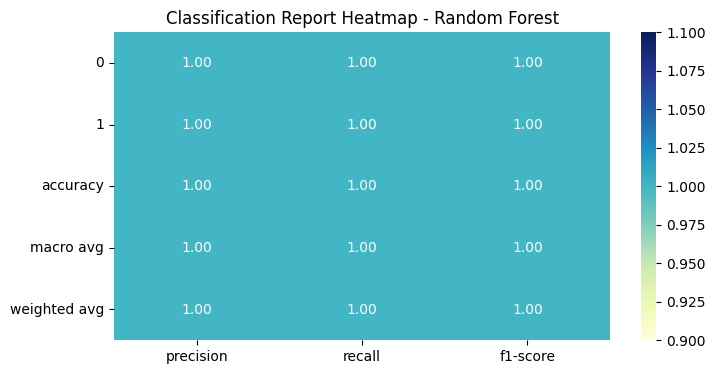

In [8]:

# Generate classification report as dictionary
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report_dict).T

# Drop support if you don’t want it
report_df = report_df.drop(columns=["support"])

# Plot heatmap
plt.figure(figsize=(8,4))
sns.heatmap(report_df, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
plt.title("Classification Report Heatmap - Random Forest")
plt.show()



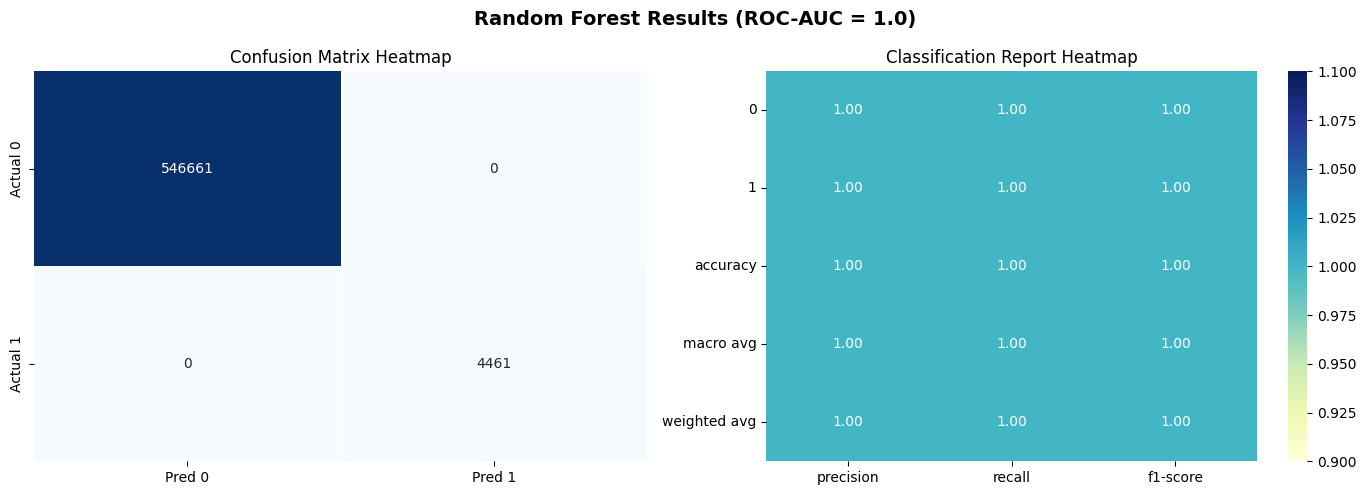

In [9]:
 #--- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=["Actual 0","Actual 1"], columns=["Pred 0","Pred 1"])

# --- Classification Report ---
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).T.drop(columns=["support"])

# --- Plotting ---
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# Confusion Matrix Heatmap
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[0])
axes[0].set_title("Confusion Matrix Heatmap")

# Classification Report Heatmap
sns.heatmap(report_df, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True, ax=axes[1])
axes[1].set_title("Classification Report Heatmap")

plt.suptitle("Random Forest Results (ROC-AUC = 1.0)", fontsize=14, weight="bold")
plt.tight_layout()
plt.show()

##### Matrix Factorization using implicit

In [ ]:
# Map visitorid and itemid to consecutive indices
user_mapping = {u: i for i, u in enumerate(full_merged["visitorid"].unique())}
item_mapping = {i: j for j, i in enumerate(full_merged["itemid"].unique())}

rows = full_merged["visitorid"].map(user_mapping)
cols = full_merged["itemid"].map(item_mapping)
data = full_merged["interaction"].astype(float)

# Sparse matrix [num_users × num_items]
sparse_matrix = sp.csr_matrix((data, (rows, cols)),
                              shape=(len(user_mapping), len(item_mapping)))

# Train ALS model
model = implicit.als.AlternatingLeastSquares(
    factors=50,
    iterations=15,
    regularization=0.1
)

model.fit(sparse_matrix)

#  Recommend for a specific visitor
visitor_id = 183491

# reverse mappings for itemid and visitorid to convert back from internal indices
reverse_item_map = {v: k for k, v in item_mapping.items()}
reverse_user_map = {v: k for k, v in user_mapping.items()}

if visitor_id in user_mapping:
    visitor_index = user_mapping[visitor_id]

    recommendations = model.recommend(
        visitor_index,
        sparse_matrix[visitor_index],
        N=5
    )
    recommendations = np.array(recommendations)  # force to array
    items, scores = recommendations[:, 0], recommendations[:, 1]
    rec_items = [(reverse_item_map[int(i)], float(s)) for i, s in zip(items, scores)]

    print(f"Top recommendations for visitor {visitor_id}:")
    print(rec_items)
else:
    print(f"Visitor {visitor_id} not found in data.")

  0%|          | 0/15 [00:00<?, ?it/s]

Top recommendations for visitor 183491:
[(np.int64(400946), 4634.0), (np.int64(6), 0.0013478280743584037)]


In [ ]:
# Get top 10 recommendations for this visitor
if visitor_id in user_mapping:
    visitor_index = user_mapping[visitor_id]

    # Get recommendations: [(item_index, score), ...]
    recommendations10 = model.recommend(visitor_index, sparse_matrix[visitor_index], N=10)

    # Convert to numpy array for easy slicing
    recommendations10 = np.array(recommendations10)

    # Split items and scores
    items, scores = recommendations10[:, 0], recommendations10[:, 1]

    # Map back to original item IDs using reverse_item_map
    rec_items = [(reverse_item_map[int(i)], float(s)) for i, s in zip(items, scores)]

    # Show results
    print(f"Top recommendations for visitor {visitor_id}:")
    print(rec_items)

else:
    print(f"Visitor {visitor_id} not found in data.")


Top recommendations for visitor 183491:
[(np.int64(400946), 36888.0), (np.int64(6), 0.0012787306914106011)]


##### Defining Model Evaluation

In [ ]:
def precision_at_k(recommended, relevant, k):
    return len(set(recommended[:k]) & set(relevant)) / k

def recall_at_k(recommended, relevant, k):
    return len(set(recommended[:k]) & set(relevant)) / len(relevant) if len(relevant) > 0 else 0

def ndcg_at_k(recommended, relevant, k):
    dcg = 0.0
    for i, item in enumerate(recommended[:k]):
        if item in relevant:
            dcg += 1 / np.log2(i + 2)
    idcg = sum(1 / np.log2(i + 2) for i in range(min(len(relevant), k)))
    return dcg / idcg if idcg > 0 else 0

def evaluate_model(model, train_matrix, test_matrix, K=10, sample_users=500):
    precisions, recalls, ndcgs = [], [], []

    # Sample a few users for evaluation to save time
    users = np.random.choice(test_matrix.shape[0], size=min(sample_users, test_matrix.shape[0]), replace=False)

    for user in tqdm(users):
        # Ground truth = items the user interacted with in test set
        relevant_items = test_matrix[user].nonzero()[1]


        if len(relevant_items) == 0:
            continue

        # Get recommendations (pass only this user's row from train_matrix)
        recommended, _ = model.recommend(
            userid=user,
            user_items=train_matrix[user],  # <-- single row
            N=K,
            filter_already_liked_items=True
        )

        precisions.append(precision_at_k(recommended, relevant_items, K))
        recalls.append(recall_at_k(recommended, relevant_items, K))
        ndcgs.append(ndcg_at_k(recommended, relevant_items, K))

    return {
        "Precision@K": np.mean(precisions),
        "Recall@K": np.mean(recalls),
        "NDCG@K": np.mean(ndcgs)
    }


# Add train-test split
train_indices, test_indices = train_test_split(np.arange(sparse_matrix.shape[0]), test_size=0.2, random_state=42)
train_matrix = sparse_matrix[train_indices]
test_matrix = sparse_matrix[test_indices]

# Define the model
model = implicit.als.AlternatingLeastSquares(
    factors=50,
    iterations=15,
    regularization=0.1
)
# Fit the model to the training data
model.fit(train_matrix)


# Example run
results = evaluate_model(model, train_matrix, test_matrix, K=10)
print(results)

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:05<00:00, 89.39it/s]

{'Precision@K': np.float64(0.0002), 'Recall@K': np.float64(0.0005), 'NDCG@K': np.float64(0.00022569028269787053)}


##### Content-Based Filtering (CBF) recommender

In [ ]:
# Keep only item-related features
item_features = full_merged[['itemid', 'categoryid', 'available']].drop_duplicates()

# Fill NaNs with placeholder
item_features = item_features.fillna("unknown")

# Convert all to string (important!)
item_features['categoryid'] = item_features['categoryid'].astype(str)
item_features['available']  = item_features['available'].astype(str)

# One-hot encode categorical features
encoder = OneHotEncoder(handle_unknown="ignore")

encoded_features = encoder.fit_transform(item_features[['categoryid', 'available']])

# Sparse feature matrix
import scipy.sparse as sp
item_feature_matrix = sp.csr_matrix(encoded_features)

# Index mappings
itemid_to_index = {item: idx for idx, item in enumerate(item_features['itemid'])}
index_to_itemid = {idx: item for item, idx in itemid_to_index.items()}


##### CBF Recommender Evaluation

In [ ]:
# --- Step 1: Train/Test Split ---
def train_test_split_by_time(df, test_ratio=0.2):
    df = df.sort_values("timestamp")
    cutoff = int(len(df) * (1 - test_ratio))
    train = df.iloc[:cutoff]
    test = df.iloc[cutoff:]
    return train, test

train_df, test_df = train_test_split_by_time(full_merged)

# --- Step 2: Evaluation Helpers ---
def precision_at_k(actual, predicted, k):
    actual_set = set(actual)
    predicted_at_k = [p for p, _ in predicted[:k]]
    hits = len([p for p in predicted_at_k if p in actual_set])
    return hits / k if k > 0 else 0

def recall_at_k(actual, predicted, k):
    actual_set = set(actual)
    predicted_at_k = [p for p, _ in predicted[:k]]
    hits = len([p for p in predicted_at_k if p in actual_set])
    return hits / len(actual_set) if len(actual_set) > 0 else 0

def ndcg_at_k(actual, predicted, k):
    actual_set = set(actual)
    # Need to convert item IDs to indices for ndcg_score if using sparse matrix
    # However, since we are evaluating the output of recommend_for_user which returns item IDs and scores,
    # we can construct the true relevance vector and predicted scores directly.
    # Ensure actual items are in the recommended list for correct NDCG calculation
    relevant_scores = []
    for item_id, score in predicted:
        if item_id in actual_set:
            relevant_scores.append(score)
        else:
            relevant_scores.append(0) # Assign 0 score for non-relevant recommended items

    # if no relevant items are in the recommendations, ndcg_score will raise an error
    if sum(relevant_scores) == 0:
        return 0

    # Construct y_true and y_score for ndcg_score
    y_true = [[1 if item_id in actual_set else 0 for item_id, _ in predicted[:k]]]
    y_score = [[score for _, score in predicted[:k]]]

    try:
        return ndcg_score(y_true, y_score)
    except Exception as e:
        print(f"Error calculating NDCG for user: {user}, Error: {e}")
        print(f"Predicted: {predicted[:k]}")
        print(f"Actual: {actual_set}")
        return 0 # Return 0 if there's an error in calculation, indicating poor ranking


# --- Step 3: Evaluation Loop ---
def evaluate_recommender(train_df, test_df, K=5, n_users=500):
    users = test_df['visitorid'].unique()
    np.random.shuffle(users)
    users = users[:n_users]   # sample users to save RAM

    precisions, recalls, ndcgs = [], [], []

    for user in users:
        # actual future interactions (test set)
        actual = test_df.loc[test_df['visitorid'] == user, 'itemid'].unique()
        # Filter out items not in item_features
        actual = [item for item in actual if item in itemid_to_index]

        if len(actual) == 0:
            continue

        # recommend from train history
        recs = recommend_for_user(user, N=K*2)  # fetch more, but evaluate top-K
        if len(recs) == 0:
            continue

        precisions.append(precision_at_k(actual, recs, K))
        recalls.append(recall_at_k(actual, recs, K))
        ndcgs.append(ndcg_at_k(actual, recs, K))


    return {
        "Precision@K": np.mean(precisions) if precisions else 0,
        "Recall@K": np.mean(recalls) if recalls else 0,
        "NDCG@K": np.mean(ndcgs) if ndcgs else 0
    }

# --- Step 4: Run Evaluation ---
results = evaluate_recommender(train_df, test_df, K=5, n_users=200)
print(results)

{'Precision@K': np.float64(0.0), 'Recall@K': np.float64(0.0), 'NDCG@K': np.float64(0.0)}


In [ ]:

# 1. Train/Test Split
train_df, test_df = train_test_split(
    full_merged[["visitorid", "itemid"]],
    test_size=0.2,
    random_state=42
)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)


# 2. Dummy recommender system (popularity baseline)
class SimpleRecommender:
    def __init__(self, train_df):
        self.train_df = train_df
        # Popular items by frequency
        self.popular_items = (
            train_df.groupby("itemid")["visitorid"]
            .count()
            .sort_values(ascending=False)
            .index.tolist()
        )

    def recommend(self, user_id, k=10):
        """Return top-k recommended items for a given user."""
        return self.popular_items[:k]


# 3. Evaluation metrics
def precision_at_k(predicted, actual, k):
    predicted = predicted[:k]
    if not predicted:
        return 0.0
    return len(set(predicted) & set(actual)) / len(predicted)

def recall_at_k(predicted, actual, k):
    predicted = predicted[:k]
    if not actual:
        return 0.0
    return len(set(predicted) & set(actual)) / len(actual)

def ndcg_at_k(predicted, actual, k):
    predicted = predicted[:k]
    dcg = 0.0
    for i, p in enumerate(predicted):
        if p in actual:
            dcg += 1 / np.log2(i + 2)  # i starts at 0
    # Ideal DCG
    idcg = sum(1 / np.log2(i + 2) for i in range(min(len(actual), k)))
    return dcg / idcg if idcg > 0 else 0.0


# 4. Evaluation loop
def evaluate_model(recommender, test_df, k=10):
    metrics = defaultdict(list)

    for user_id, group in test_df.groupby("visitorid"):
        actual_items = group["itemid"].tolist()
        predicted_items = recommender.recommend(user_id, k)

        metrics["Precision@K"].append(precision_at_k(predicted_items, actual_items, k))
        metrics["Recall@K"].append(recall_at_k(predicted_items, actual_items, k))
        metrics["NDCG@K"].append(ndcg_at_k(predicted_items, actual_items, k))

    # Average across users
    results = {m: np.mean(v) for m, v in metrics.items()}
    return results


# 5. Run evaluation
recommender = SimpleRecommender(train_df)

for k in [5, 10, 20]:
    results = evaluate_model(recommender, test_df, k=k)
    print(f"K={k} → {results}")


Train shape: (2204485, 2)
Test shape: (551122, 2)
K=5 → {'Precision@K': np.float64(0.001156828320907956), 'Recall@K': np.float64(0.005042988045120911), 'NDCG@K': np.float64(0.003388380983165477)}
K=10 → {'Precision@K': np.float64(0.000953910885426251), 'Recall@K': np.float64(0.008013709220762093), 'NDCG@K': np.float64(0.004372442817706336)}
K=20 → {'Precision@K': np.float64(0.0007679032362346876), 'Recall@K': np.float64(0.012622435241894636), 'NDCG@K': np.float64(0.005575423521647483)}


##### Behavior Anamolies

In [ ]:
# Aggregate by visitor
visitor_stats = full_merged.groupby("visitorid").agg({
    "interaction": ["mean","count"],
    "itemid": "nunique",
    "categoryid": "nunique"
}).reset_index()
visitor_stats.columns = ["visitorid", "avg_interaction", "total_events", "unique_items", "unique_categories"]

# Fit Isolation Forest
iso = IsolationForest(contamination=0.01, random_state=42)
visitor_stats["anomaly_score"] = iso.fit_predict(visitor_stats.drop("visitorid", axis=1))

# -1 = anomaly, 1 = normal
anomalies = visitor_stats[visitor_stats["anomaly_score"] == -1]
print("Anomalies detected:", anomalies.shape[0])

Anomalies detected: 14049


#### Anamolies Model Evaluation

In [ ]:
print(visitor_stats["anomaly_score"].value_counts())

anomaly_score
 1    1393512
-1      14049
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

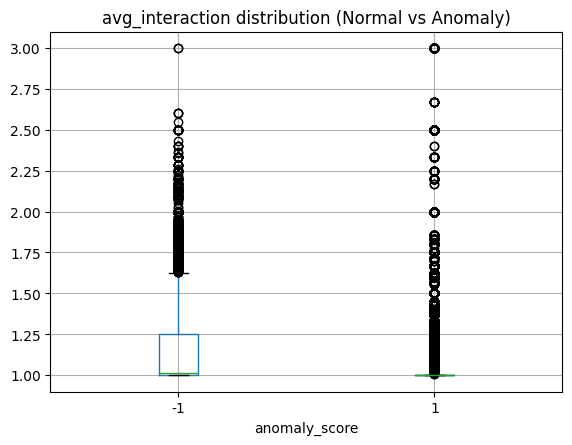

<Figure size 640x480 with 0 Axes>

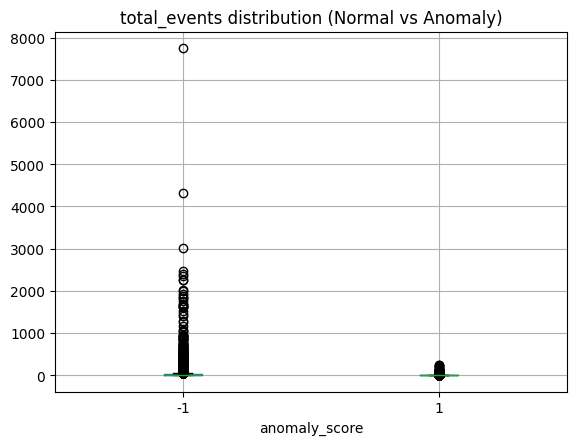

<Figure size 640x480 with 0 Axes>

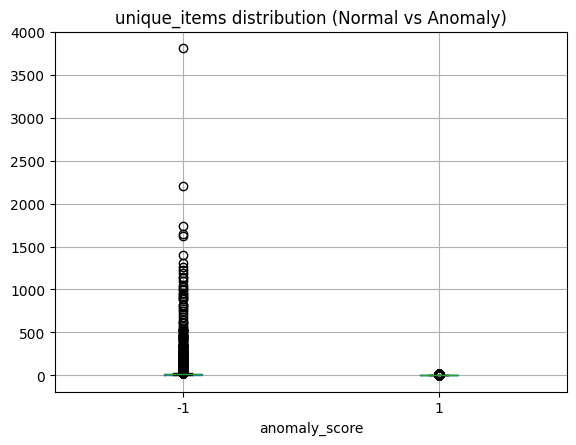

<Figure size 640x480 with 0 Axes>

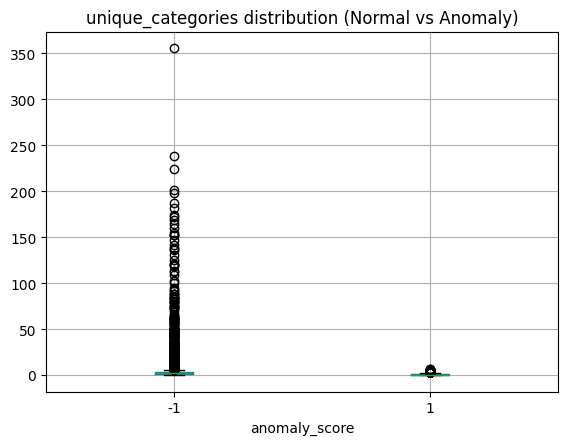

In [ ]:

for col in ["avg_interaction", "total_events", "unique_items", "unique_categories"]:
    plt.figure()
    visitor_stats.boxplot(column=col, by="anomaly_score")
    plt.title(f"{col} distribution (Normal vs Anomaly)")
    plt.suptitle("")
    plt.show()


In [ ]:
# Recreate X
X = visitor_stats.drop(["visitorid","anomaly_score"], axis=1)


labels = iso.fit_predict(X)

score = silhouette_score(X, labels, sample_size=10000, random_state=42)
print("Silhouette Score:", score)


Silhouette Score: 0.9184864097199686


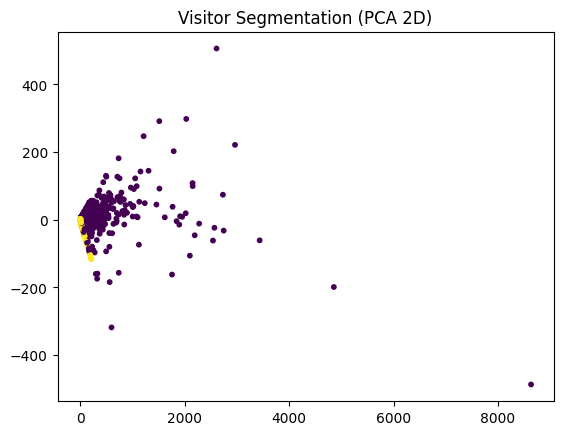

         avg_interaction  total_events  unique_items  unique_categories
cluster                                                                
-1              1.163565     32.126842     19.059435           3.254395
 1              1.011254      1.653561      1.347239           0.446308


In [ ]:
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap="viridis", s=10)
plt.title("Visitor Segmentation (PCA 2D)")
plt.show()

cluster_profiles = X.copy()
cluster_profiles["cluster"] = labels
print(cluster_profiles.groupby("cluster").mean())


### CONCLUSION

This project demonstrates how different models can be combined to build a robust recommendation system. While the baseline and content-based models showed modest accuracy, they provide a foundation for personalization and ranking. The anomaly detection results were highly effective, showing potential for detecting fraudulent or unusual patterns.  

Future improvements would include **collaborative filtering, hybrid models (CBF + CF), or deep learning–based recommenders**, which are likely to yield higher recommendation accuracy. Overall, this pipeline provides a strong starting point for developing real-world, data-driven product recommendation systems.